In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [4]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [5]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [6]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [7]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [8]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(452, 140, 22)
(382, 140, 18)
(844, 140, 22)
(452, 4)
(382, 4)
(844, 4)


In [9]:
def split_to_test_train_data(X_List,Y_List,ratio,time_step,dimX,nbr_of_classes):
    
    nbr_of_data = len(X_List)
    min_samples = min([x.shape[0] for x in X_List])
    h = int((1-ratio)*min_samples)
    nbr_of_test = [x.shape[0]-h for x in X_List]
    X = np.zeros((h*nbr_of_data,time_step,dimX))
    Y = np.zeros((h*nbr_of_data,nbr_of_classes))
    X_Test_List = [np.zeros((sum(nbr_of_test),time_step,dimX))]
    Y_Test_List = [np.zeros((sum(nbr_of_test),nbr_of_classes))]
    
    for i in range(nbr_of_data):
        x_d = np.zeros((nbr_of_test[i],time_step,dimX))
        y_d = np.zeros((nbr_of_test[i],nbr_of_classes))
        X_Test_List.append(x_d)
        Y_Test_List.append(y_d)

    test_samp_prev = 0 
    for i in range(nbr_of_data):
        x = X_List[i][:,:,:dimX]
        y = Y_List[i]
        test_samp = nbr_of_test[i] + test_samp_prev
        X[h*i:h*(i+1),:,:] = x[:h,:,:]
        Y[h*i:h*(i+1),:] = y[:h,:]
        X_Test_List[0][test_samp_prev:test_samp,:,:] = x[h:,:,:]
        Y_Test_List[0][test_samp_prev:test_samp,:] = y[h:,:]
        X_Test_List[i+1] = x[h:,:,:]
        Y_Test_List[i+1] = y[h:,:]
        test_samp_prev = test_samp
        
    return X,Y,X_Test_List,Y_Test_List

In [10]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]
ratio = 0.2
time_step = 140
nbr_of_classes = 4
X,Y,X_Test_List,Y_Test_List = split_to_test_train_data(X_List,Y_List,ratio,time_step,dim_X,nbr_of_classes)
X_Test = X_Test_List[0]
Y_Test = Y_Test_List[0]

In [11]:
print(X.shape)
print(Y.shape)
print(X_Test.shape)
print(Y_Test.shape)

(915, 140, 17)
(915, 4)
(763, 140, 17)
(763, 4)


In [12]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [13]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [14]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [15]:
delta_t = 0.02
X = change_time_axis_for_plot(X,delta_t)
X_Test = change_time_axis_for_plot(X_Test,delta_t)

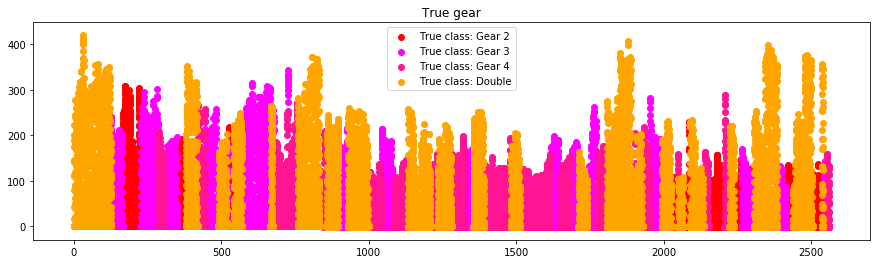

In [16]:
true_Y = np.argmax(Y,axis = 1)
figure = plot_skiedata(true_Y,X,0)

In [17]:
def CNN_One_Layer_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_38():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 38, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
def CNN_One_Layer_52():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_72():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 72, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 126, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



Training model: CNN_One_Layer_26
Train on 915 samples, validate on 763 samples
Epoch 1/20
915/915 [==============================] - 4s 5ms/step - loss: 3.1544 - acc: 0.5421 - val_loss: 1.9729 - val_acc: 0.5570
Epoch 2/20
915/915 [==============================] - 3s 4ms/step - loss: 1.1437 - acc: 0.6929 - val_loss: 1.4506 - val_acc: 0.6317
Epoch 3/20
915/915 [==============================] - 3s 4ms/step - loss: 0.7418 - acc: 0.7869 - val_loss: 1.2774 - val_acc: 0.6435
Epoch 4/20
915/915 [==============================] - 3s 4ms/step - loss: 0.5678 - acc: 0.8164 - val_loss: 0.9014 - val_acc: 0.7182
Epoch 5/20
915/915 [==============================] - 4s 4ms/step - loss: 0.4381 - acc: 0.8568 - val_loss: 0.8211 - val_acc: 0.7457
Epoch 6/20
915/915 [==============================] - 4s 4ms/step - loss: 0.3885 - acc: 0.8656 - val_loss: 0.8264 - val_acc: 0.7654
Epoch 7/20
915/915 [==============================] - 4s 4ms/step - loss: 0.3512 - acc: 0.8863 - val_loss: 0.6269 - val_acc: 0.82

Done!
Training model: CNN_One_Layer_72
Train on 915 samples, validate on 763 samples
Epoch 1/20
915/915 [==============================] - 6s 7ms/step - loss: 1.9295 - acc: 0.5858 - val_loss: 1.0461 - val_acc: 0.6684
Epoch 2/20
915/915 [==============================] - 5s 5ms/step - loss: 0.8432 - acc: 0.7432 - val_loss: 0.8618 - val_acc: 0.7090
Epoch 3/20
915/915 [==============================] - 5s 6ms/step - loss: 0.5211 - acc: 0.8295 - val_loss: 0.5445 - val_acc: 0.8231
Epoch 4/20
915/915 [==============================] - 5s 5ms/step - loss: 0.4069 - acc: 0.8590 - val_loss: 1.0001 - val_acc: 0.7261
Epoch 5/20
915/915 [==============================] - 5s 6ms/step - loss: 0.3752 - acc: 0.8754 - val_loss: 1.1415 - val_acc: 0.7235
Epoch 6/20
915/915 [==============================] - 5s 5ms/step - loss: 0.3472 - acc: 0.9027 - val_loss: 0.8577 - val_acc: 0.8008
Epoch 7/20
915/915 [==============================] - 5s 6ms/step - loss: 0.3115 - acc: 0.9049 - val_loss: 0.5757 - val_acc

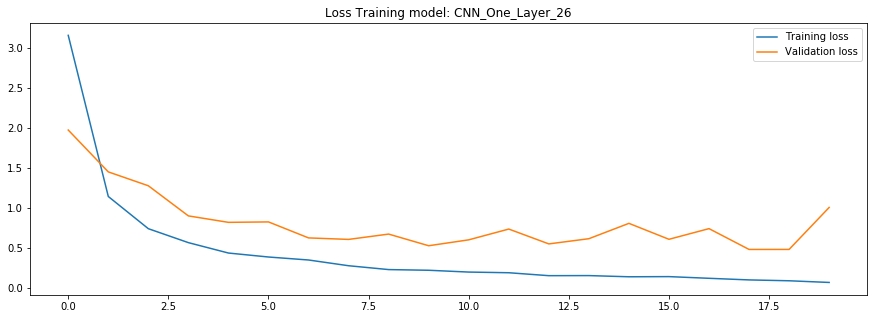

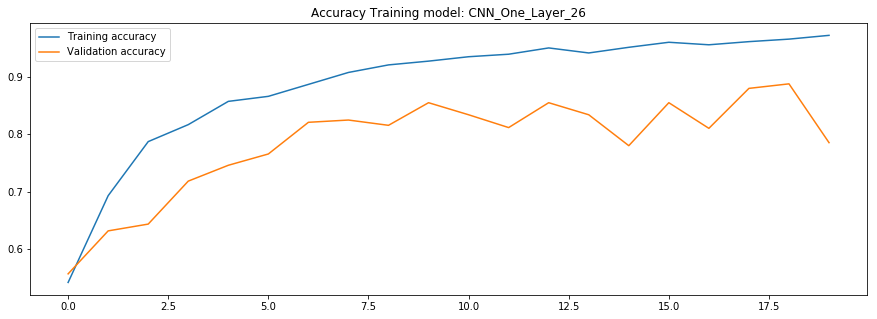

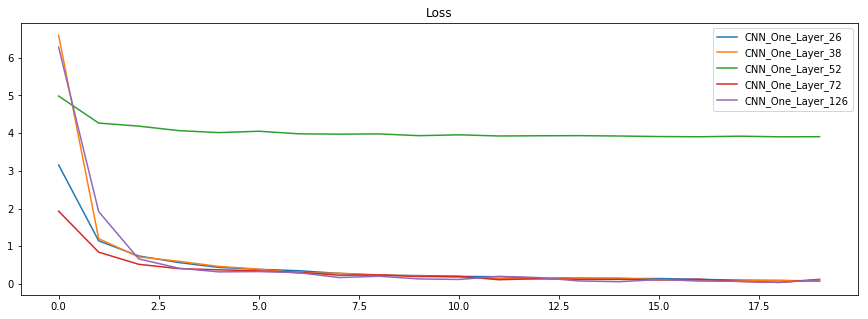

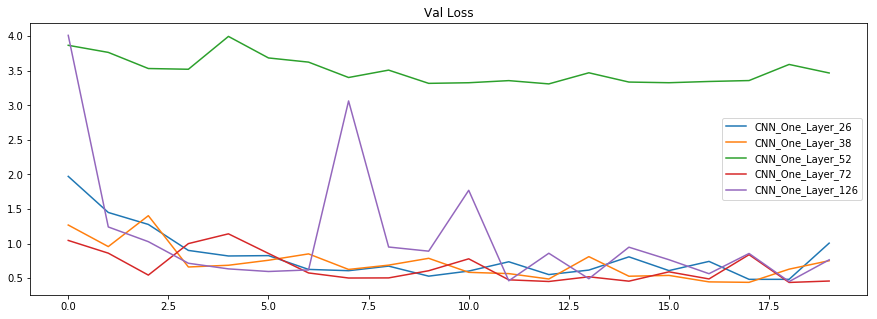

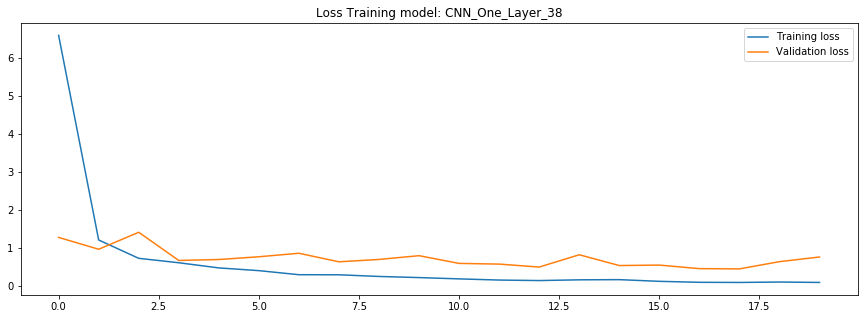

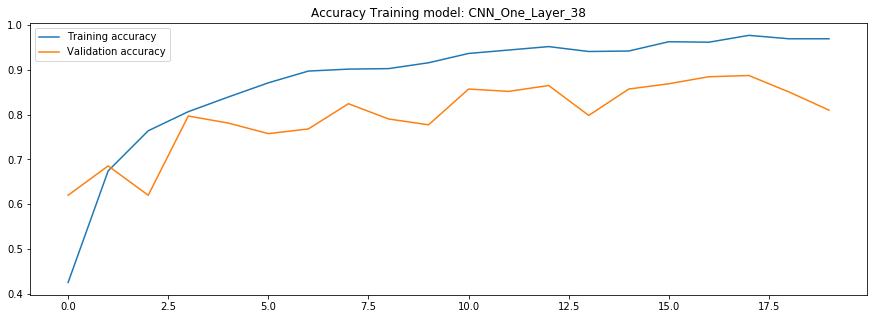

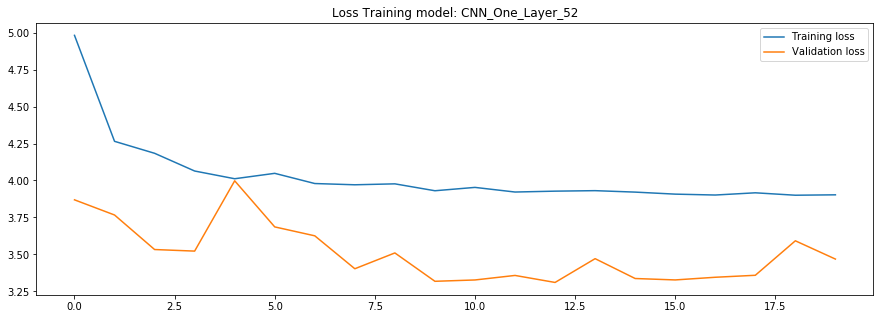

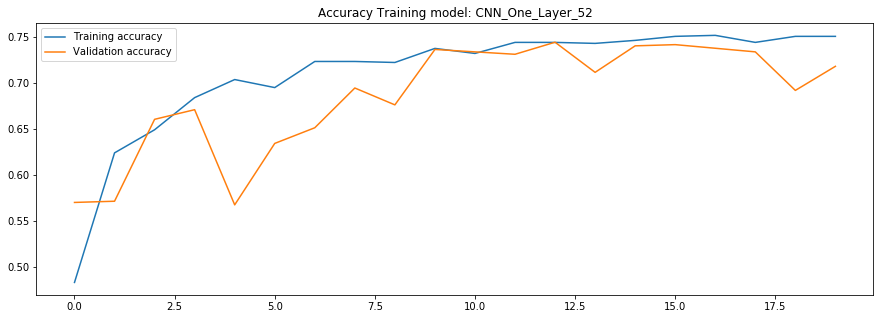

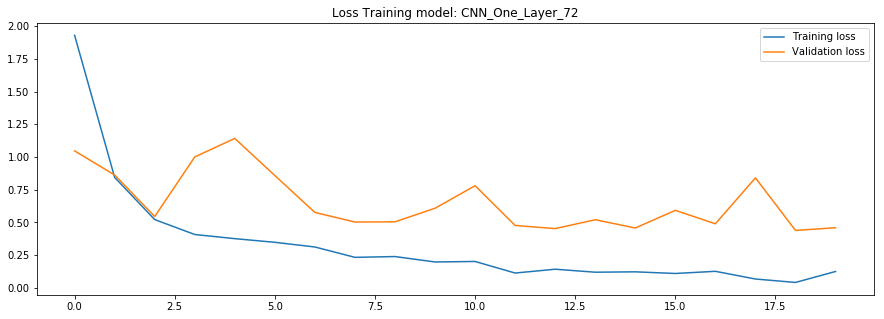

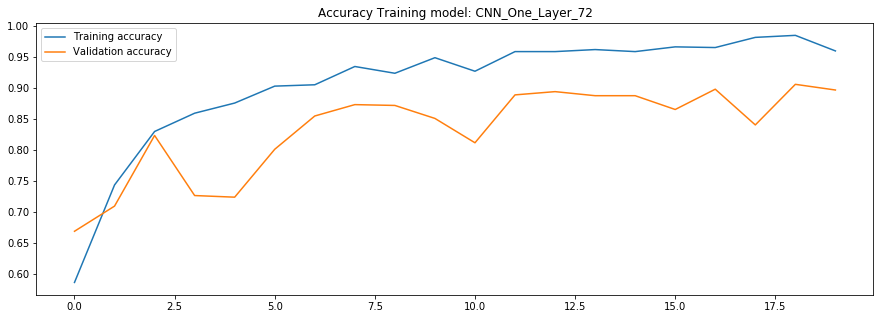

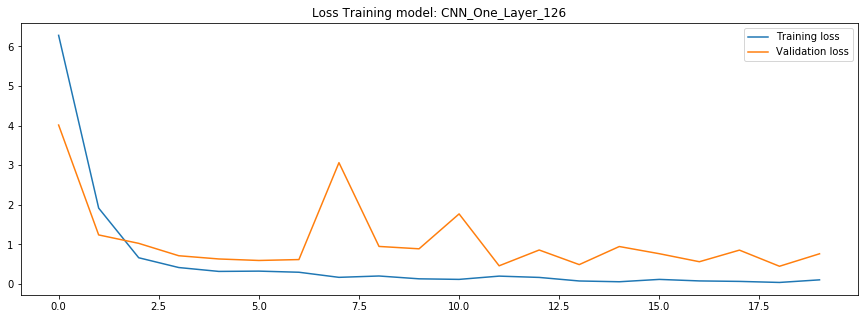

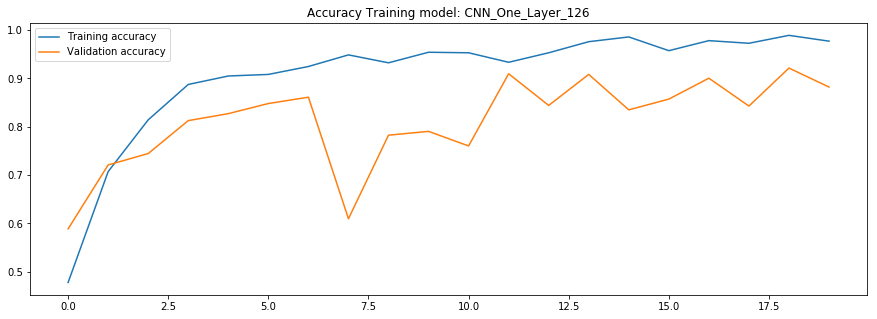

In [22]:
model_names = ['CNN_One_Layer_26','CNN_One_Layer_38','CNN_One_Layer_52','CNN_One_Layer_72','CNN_One_Layer_126']
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
i = 0
for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    #tb = TensorBoard(log_dir='./logs/'+name)
    history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Test[:,:,1:],Y_Test),shuffle = True,callbacks = [eS])
    print('Done!')
    plt.figure(2*i,[15,5])
    plt.title('Loss Training model: ' + name)
    plt.plot(history.history['loss'],label = 'Training loss')
    plt.plot(history.history['val_loss'],label = 'Validation loss')
    plt.legend()
    plt.figure(2*i + 1,[15,5])
    plt.plot(history.history['acc'],label = 'Training accuracy')
    plt.plot(history.history['val_acc'],label = 'Validation accuracy')
    plt.title('Accuracy Training model: ' + name)
    plt.legend()
    plt.figure(2*len(model_names),[15,5])
    plt.title('Loss')
    plt.plot(history.history['loss'],label = name)
    plt.legend()
    plt.figure(2*len(model_names) + 1,[15,5])
    plt.title('Val Loss')
    plt.plot(history.history['val_loss'],label = name)
    plt.legend()

    i = i + 1 

In [18]:
def CNN_Two_Layer_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = MaxPooling1D(5)(x)
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_Two_Layer_52():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(sequence_input)
    x = MaxPooling1D(5)(x)
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Training model: CNN_Two_Layer_26
Train on 915 samples, validate on 763 samples
Epoch 1/20
915/915 [==============================] - 5s 6ms/step - loss: 4.1442 - acc: 0.4699 - val_loss: 0.9427 - val_acc: 0.6671
Epoch 2/20
915/915 [==============================] - 4s 4ms/step - loss: 0.7882 - acc: 0.7148 - val_loss: 0.9570 - val_acc: 0.6488
Epoch 3/20
915/915 [==============================] - 4s 4ms/step - loss: 0.5257 - acc: 0.8066 - val_loss: 0.7751 - val_acc: 0.7143
Epoch 4/20
915/915 [==============================] - 4s 4ms/step - loss: 0.3849 - acc: 0.8503 - val_loss: 0.7906 - val_acc: 0.7339
Epoch 5/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2883 - acc: 0.8984 - val_loss: 0.9563 - val_acc: 0.7051
Epoch 6/20
915/915 [==============================] - 4s 4ms/step - loss: 0.2251 - acc: 0.9148 - val_loss: 0.5478 - val_acc: 0.8126
Epoch 7/20
915/915 [==============================] - 4s 4ms/step - loss: 0.1942 - acc: 0.9344 - val_loss: 0.4280 - val_acc: 0.86

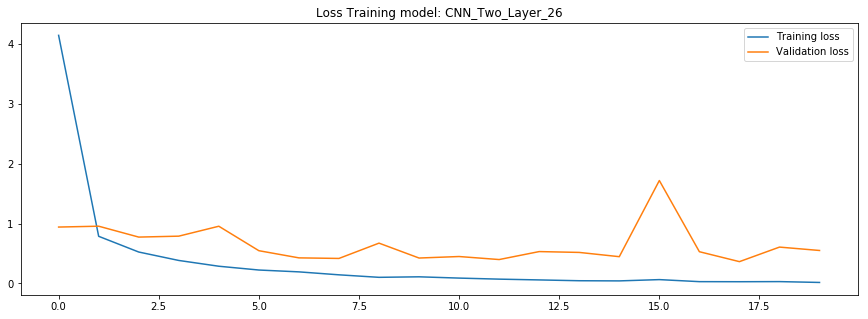

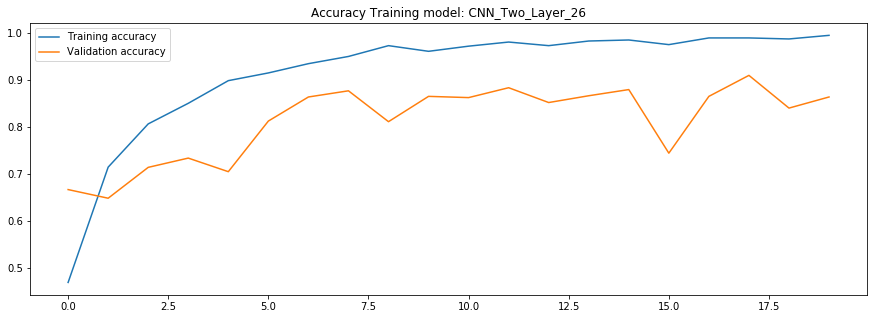

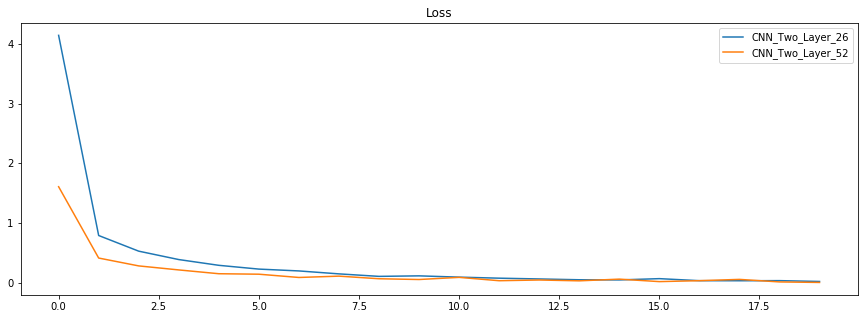

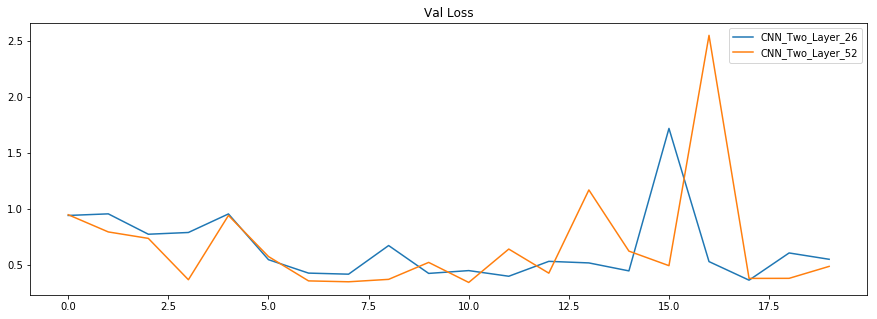

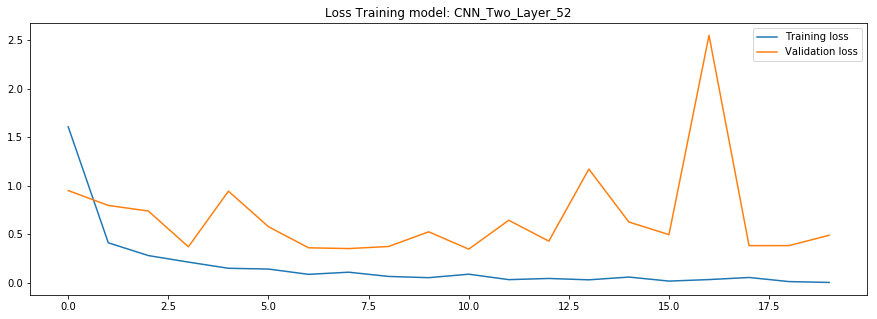

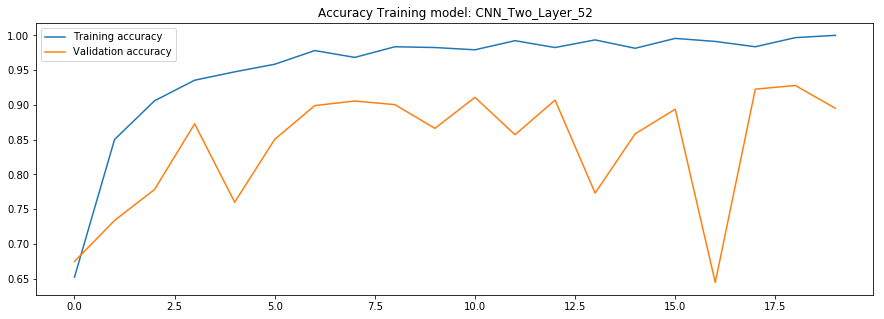

In [24]:
model_names = ['CNN_Two_Layer_26','CNN_Two_Layer_52']
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
i = 0
for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    #tb = TensorBoard(log_dir='./logs/'+name)
    history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Test[:,:,1:],Y_Test),shuffle = True,callbacks = [eS])
    print('Done!')
    plt.figure(2*i,[15,5])
    plt.title('Loss Training model: ' + name)
    plt.plot(history.history['loss'],label = 'Training loss')
    plt.plot(history.history['val_loss'],label = 'Validation loss')
    plt.legend()
    plt.figure(2*i + 1,[15,5])
    plt.plot(history.history['acc'],label = 'Training accuracy')
    plt.plot(history.history['val_acc'],label = 'Validation accuracy')
    plt.title('Accuracy Training model: ' + name)
    plt.legend()
    plt.figure(2*len(model_names),[15,5])
    plt.title('Loss')
    plt.plot(history.history['loss'],label = name)
    plt.legend()
    plt.figure(2*len(model_names) + 1,[15,5])
    plt.title('Val Loss')
    plt.plot(history.history['val_loss'],label = name)
    plt.legend()

    i = i + 1 

In [19]:
model = CNN_Two_Layer_52()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
mCp = ModelCheckpoint('CNN_1_2_3.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Test[:,:,1:],Y_Test),shuffle = True,callbacks = [eS,mCp])

Train on 915 samples, validate on 763 samples
Epoch 1/20
915/915 [==============================] - 6s 7ms/step - loss: 1.3879 - acc: 0.6153 - val_loss: 1.2197 - val_acc: 0.6252
Epoch 2/20
915/915 [==============================] - 5s 6ms/step - loss: 0.4772 - acc: 0.8339 - val_loss: 0.5679 - val_acc: 0.8034
Epoch 3/20
915/915 [==============================] - 5s 5ms/step - loss: 0.2617 - acc: 0.9038 - val_loss: 0.6858 - val_acc: 0.7824
Epoch 4/20
915/915 [==============================] - 5s 5ms/step - loss: 0.1919 - acc: 0.9246 - val_loss: 0.4289 - val_acc: 0.8729
Epoch 5/20
915/915 [==============================] - 5s 5ms/step - loss: 0.1065 - acc: 0.9607 - val_loss: 1.0479 - val_acc: 0.7523
Epoch 6/20
915/915 [==============================] - 5s 5ms/step - loss: 0.1330 - acc: 0.9388 - val_loss: 0.4042 - val_acc: 0.8978
Epoch 7/20
915/915 [==============================] - 5s 5ms/step - loss: 0.1052 - acc: 0.9672 - val_loss: 0.5078 - val_acc: 0.8650
Epoch 8/20
915/915 [==========

In [20]:
from keras.models import load_model
model = load_model('CNN_1_2_3.h5')
predY = model.predict(X_Test[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(763, 4)
Accuracy: 0.94
